# Naive Bayes: análisis de sentimiento de reseñas de películas

Basado en parte en el capítulo 8 del libro "Real-world machine learning", de Henrik Brink, Joseph W. Richards y Mark Fetherolf, Manning, 2017.

El dataset que se va a analizar contiene las reseñas de 25000 películas de IMDB (sitio web de base de datos de películas) con una calificación de sentimiento positivo (1) o negativo (0).

En este taller vamos a crear un clasificador con el modelo de Naïve Bayes que permita identificar si un review de una película tiende hacia una calificación "buena" o "mala", a partir del análisis de las palabras utilizadas.

## Preparación de los datos

El archivo "05-01-ImdbLabeledData.tsv" contiene el dataset de reseñas de películas. Tiene tres campos:
- id: ID de la película, tipo string (realmente no lo vamos a utilizar par la tarea en cuestión)
- sentiment: Sentimiento de la reseña, tipo binario, con 1 representando positivo y 0 representando negativo
- review: reseña de la película, tipo string

Vamos a dividir el dataset en 2: 70% para entrenamiento, 30% para test.

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.feature_extraction.text import CountVectorizer #herramienta para convertir textos en palabras atributos
#from sklearn.model_selection import KFold, cross_val_score #protocolo de evaluación
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
#from sklearn import preprocessing 
#import seaborn as sns

Cargamos los datos en memoria y lo entendemos superficialmente.

In [2]:
data = pd.read_csv('06-01-ImdbLabeledData.tsv', sep="\t")
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


Vemos que todos los registros de las películas tienen reseña y su correspondiente calificación de sentimiento.

In [4]:
data.dtypes

id           object
sentiment     int64
review       object
dtype: object

In [5]:
data.describe(include="all")

,id,sentiment,review
count,25000,25000.00000,25000
unique,25000,NaN,24904
top,11225_3,NaN,You do realize that you've been watching the E...
freq,1,NaN,3
mean,NaN,0.50000,NaN
std,NaN,0.50001,NaN
min,NaN,0.00000,NaN
25%,NaN,0.00000,NaN
50%,NaN,0.50000,NaN
75%,NaN,1.00000,NaN


Podemos ver que el campo sentiment fue leido como un entero, con la mitad de las reseñas positivas y la mitad negativas (el promedio es 0.5). 

## Cambio de representación de los datos

Particionamos los datos (protocolo holdout) y cambiamos la representación de las reseñas de las palabras para que pueden ser tratadas por los modelos de clasificación.

Vamos a "vectorizar" las reseñas textuales de las películas, de tal manera que cada posible palabra encontrada se convierta en un atributo descriptivo de la reseña (modelo "bag of words").

Esta vectorización se "aprende" sobre el conjunto de aprendizaje y se aplica al conjunto de evaluación. Puede que algunas palabras del primer conjunto no se encuentren en el segundo, pero en "producción" esto también es posible. En tal caso las palabras nuevas no serían tenidas en cuenta.
Si no lo hicieramos así y consideraramos todas las palabras de los 2 datasets, tendríamos "data leakage", uno de los problemas que todo modelo de analítica debe prevenir.

In [6]:
X = data.review
y = data.sentiment

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

El vectorizer creó un diccionario que mapea las palabras encontradas al índice en la matríz de atributos

In [9]:
print(len(vectorizer.vocabulary_))
vectorizer.vocabulary_

64795


{'this': 57668,
 'was': 62535,
 'my': 38615,
 'second': 50636,
 'time': 57984,
 'watching': 62591,
 'the': 57475,
 'film': 21300,
 'via': 61669,
 'french': 22590,
 'language': 32667,
 'version': 61617,
 'as': 3799,
 'opposed': 40733,
 'to': 58159,
 'first': 21486,
 'which': 63020,
 'dubbed': 17610,
 'in': 28632,
 'italian': 30127,
 'and': 2776,
 'feel': 20946,
 'that': 57459,
 'it': 30124,
 'improves': 28610,
 'on': 40582,
 'subsequent': 55432,
 'viewings': 61782,
 'br': 7499,
 'compelling': 11829,
 'if': 28197,
 'slowly': 52787,
 'built': 8239,
 'up': 60923,
 'character': 9972,
 'study': 55241,
 'beautifully': 5518,
 'shot': 51781,
 'with': 63515,
 'parisian': 41898,
 'settings': 51092,
 'being': 5707,
 'equally': 19324,
 'impressive': 28586,
 'long': 34054,
 'run': 49182,
 'not': 39842,
 'top': 58366,
 'grade': 24593,
 'polanski': 43800,
 'would': 63834,
 'rank': 46246,
 'at': 4060,
 'number': 40002,
 'his': 26969,
 'filmography': 21336,
 'but': 8519,
 'still': 54751,
 'confident': 1

Tenemos en total 64795 palabras (features) que van a describir las reseñas.
Hacemos la transformación de las reseñas textuales a este nuevo espacio descriptivo, de tipo matrix dispersa.
Este tipo de matrices optimiza el manejo del espacio, teniendo en cuenta que muchas de las celdas de reseña por palabra van a tener un valor de 0.

In [13]:
X_train_features = vectorizer.transform(X_train)
X_test_features = vectorizer.transform(X_test)
type(X_train_features)

scipy.sparse.csr.csr_matrix

Veamos un subconjunto de los términos de las reseñas (las columnas de la matriz dispersa):

In [99]:
print("Hay en total {} palabras utilizadas.".format(len(vectorizer.get_feature_names())))
print("Algunas de ellas son: ", vectorizer.get_feature_names()[1355:1450])

Hay en total 64795 palabras utilizadas.
Algunas de ellas son:  ['across', 'act', 'actally', 'acted', 'actelone', 'actess', 'acteurs', 'acteurs_', 'actin', 'acting', 'actingjob', 'actingwise', 'actio', 'action', 'action_detail', 'actiona', 'actioned', 'actioneers', 'actioner', 'actioners', 'actionmovie', 'actionpacked', 'actions', 'activate', 'activated', 'activates', 'activating', 'active', 'actively', 'actives', 'activest', 'activision', 'activism', 'activist', 'activists', 'activities', 'activity', 'actor', 'actores', 'actors', 'actreesess', 'actress', 'actresses', 'actriss', 'acts', 'actual', 'actualities', 'actuality', 'actualization', 'actuall', 'actually', 'actualy', 'actuelly', 'acual', 'acually', 'acuity', 'acumen', 'acupat', 'acurately', 'acus', 'acute', 'acutely', 'ad', 'ada', 'adabted', 'adachi', 'adage', 'adalbert', 'adam', 'adama', 'adamant', 'adamantium', 'adamantly', 'adames', 'adams', 'adamson', 'adapt', 'adaptable', 'adaptaion', 'adaptation', 'adaptations', 'adapted', 

Podemos transformar los datos a una matriz densa. Veamos el contenido de un pequeño subconjunto:

In [108]:
primera_palabra = 1355
primera_reseña = 100
palabras = vectorizer.get_feature_names()[primera_palabra:primera_palabra+15]
pd.DataFrame(X_train_features[primera_reseña:primera_reseña+15, primera_palabra:primera_palabra+15].todense(), columns=palabras)

,across,act,actally,acted,actelone,actess,acteurs,acteurs_,actin,acting,actingjob,actingwise,actio,action,action_detail
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Vemos que la matriz es *sparse*, ya que la mayoría de las casillas están vacías (son 0s).

## Modelamiento

Vamos a utilizar una versión multinomial del clasificador de Naïve Bayes, dado que los datos que vamos a manejar conteos de palabras (atributos) en cada reseña.

In [109]:
modelo = MultinomialNB(alpha=0.01) #Alpha indica el coeficiente de Laplace smoothing de las probabilidades
modelo.fit(X_train_features, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [110]:
print("Repartición de los ejemplos de aprendizaje: ", modelo.class_count_)
modelo.coef_

Repartición de los ejemplos de aprendizaje:  [8750. 8750.]


array([[-11.18925023,  -9.91654164, -19.126982  , ..., -19.126982  ,
        -14.51186149, -19.126982  ]])

## Evaluación del modelo

In [111]:
y_pred = modelo.predict(X_test_features)

In [112]:
cm= metrics.confusion_matrix(y_test, y_pred)
cm

array([[3209,  541],
       [ 666, 3084]], dtype=int64)

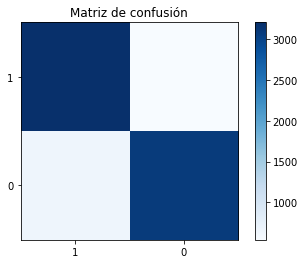

In [113]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, y.unique())
plt.yticks(tick_marks, y.unique())
plt.show()

In [115]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))
print("Precisión     : ", metrics.precision_score(y_test, y_pred))
print("Recall        : ", metrics.recall_score(y_test, y_pred))
VN = np.sum(cm[1:3,1:3])
FP = np.sum(cm[0,1:3])
specificity = VN/(VN+FP)
print("Especificidad : ", specificity)
print("F1-score      : ", metrics.f1_score(y_test, y_pred))
print("AUC           : ", metrics.roc_auc_score(y_test, y_pred))
print("-------------------------------------")

Exactitud:  0.8390666666666666
Kappa    :  0.6781333333333333
Precisión     :  0.8507586206896551
Recall        :  0.8224
Especificidad :  0.8507586206896551
F1-score      :  0.8363389830508474
AUC           :  0.8390666666666666
-------------------------------------


## Escogencia del parámetro alpha

In [116]:
acc_test_vec=[]
alpha_vec= [100, 50, 10, 5, 1, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.05, 0.01, 0.005, 0.001]
for alpha in alpha_vec:
    modelo = MultinomialNB(alpha=alpha)
    modelo.fit(X_train_features, y_train)
    y_pred = modelo.predict(X_test_features)
    acc_test_vec.append(metrics.accuracy_score(y_test, y_pred))
print(acc_test_vec)

[0.8249333333333333, 0.8330666666666666, 0.8433333333333334, 0.8438666666666667, 0.8445333333333334, 0.8448, 0.8449333333333333, 0.8457333333333333, 0.8458666666666667, 0.8458666666666667, 0.8458666666666667, 0.8458666666666667, 0.8449333333333333, 0.8446666666666667, 0.8390666666666666, 0.8378666666666666, 0.8325333333333333]


Text(0.5, 1.0, 'Evolución de le exactitud vs alpha de Laplace')

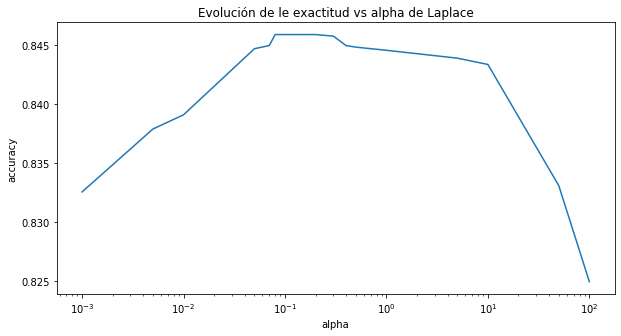

In [117]:
plt.figure(figsize=(10,5))
plt.plot(alpha_vec, acc_test_vec)

ax = plt.gca() # get current axis
plt.xscale('log') # poner el aje del X en escala logaritmica

plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs alpha de Laplace')

In [123]:
alpha_optimo = alpha_vec[np.argmax(acc_test_vec)]
acc_optima= max(acc_test_vec)
print("El óptimo se obtiene con alpha=%f, que produce un %.3f%% de exactitud" %(alpha_optimo, 100*acc_optima))

El óptimo se obtiene con alpha=0.200000, que produce un 84.587% de exactitud


In [124]:
alphas = pd.DataFrame({"alpha": alpha_vec, "accuracy": acc_test_vec})
alphas

,alpha,accuracy
0,100.000,0.824933
1,50.000,0.833067
2,10.000,0.843333
3,5.000,0.843867
4,1.000,0.844533
5,0.500,0.844800
6,0.400,0.844933
7,0.300,0.845733
8,0.200,0.845867
9,0.100,0.845867


Encontramos que con un valor de alpha entre  0.08 y 0.2 tenemos un óptimo de accuracy. Escojamos un valor de 0.1 y definamos el modelo a utilizar con ese parámetro.

In [127]:
modelo = MultinomialNB(alpha=0.1)
modelo.fit(X_train_features, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

## Predicción de sentimiento

Para evaluar el sentimiento de una reseña es necesario primero vectorizarla y luego pasarla por el modelo. Evaluemos las siguientes reseñas:
- "I don't like this movie"
- "I love this movie"
- "I really hated the film"
- "I was going to say something awesome or great or good, but i simply can't because the movie is so bad"


In [128]:
review = "I don't like this movie"
review_vec = vectorizer.transform([review])
print("{}: sentimiento={}".format(review, modelo.predict(review_vec)[0]))

review = "I really hated the film"
print("{}: sentimiento={}".format(review, modelo.predict(vectorizer.transform([review]))[0]))
review = "I love this movie"
print("{}: sentimiento={}".format(review, modelo.predict(vectorizer.transform([review]))[0]))
review = "I was going to say something awesome or great or good, but i simply can't because the movie is so bad"
print("{}: sentimiento={}".format(review, modelo.predict(vectorizer.transform([review]))[0]))


I don't like this movie: sentimiento=0
I really hated the film: sentimiento=0
I love this movie: sentimiento=1
I was going to say something awesome or great or good, but i simply can't because the movie is so bad: sentimiento=0
